In [40]:
import numpy as np
import pandas as pd
from defillama2 import DefiLlama
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)
# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

### Download Data

Let's download GMX hourly price data from Arbitrum using DefiLlama's data api. 

In [47]:
dd = {'0xfc5A1A6EB076a2C7aD06eD22C90d7E710E35ad0a':'arbitrum', # gmx, arbitrum
      }

# set download start and end dates
start_str = '2022-12-01'
end_str   = '2022-12-11'

In [46]:
llama = DefiLlama()
df = llama.get_tokens_hist_prices(dd, start_str, end_str, 'hourly')
print(df.head(), end='\n\n')
print(df.tail())

                      GMX
datetime                 
2022-12-01 00:00:00 49.26
2022-12-01 01:00:00 48.56
2022-12-01 02:00:00 48.54
2022-12-01 03:00:00 47.80
2022-12-01 04:00:00 49.08

                      GMX
datetime                 
2022-12-10 20:00:00 54.54
2022-12-10 21:00:00 54.46
2022-12-10 22:00:00 54.17
2022-12-10 23:00:00 54.37
2022-12-11 00:00:00 53.83


In [6]:
gmxusdc = df.GMXUSDC.asfreq('H')

### Check AutoCorrelation and Partial AutoCorrelation


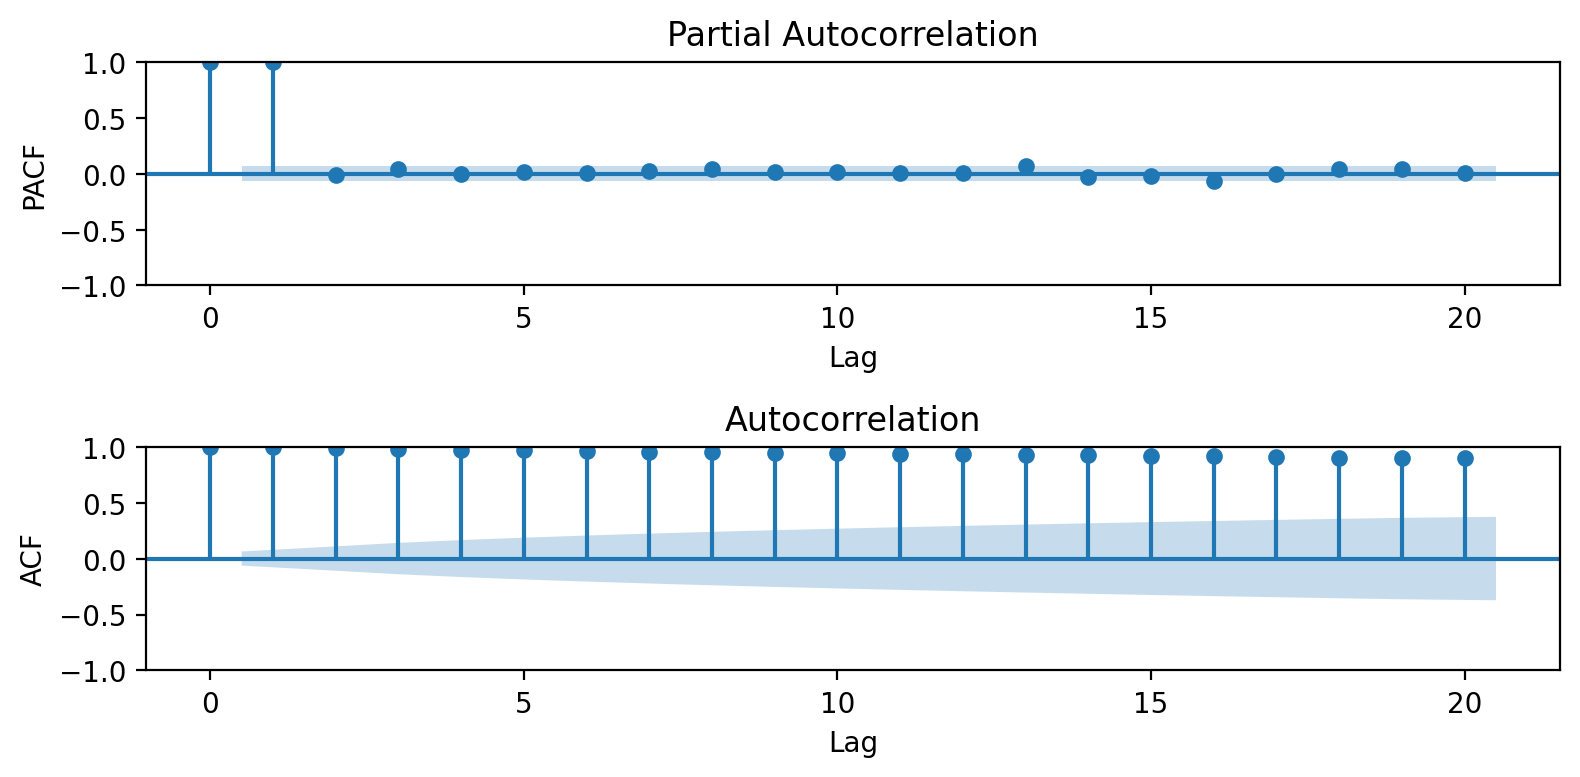

In [48]:
# make ACF and PACF plots
fig, axs = plt.subplots(2)
plot_pacf(gmxusdc, lags=20, method='ywm', ax=axs[0]) # partial autocorrelation 
axs[0].set_ylabel('PACF')
axs[0].set_xlabel('Lag')
plot_acf(gmxusdc, lags=20, ax=axs[1])  # autocorrelation
axs[1].set_ylabel('ACF')
axs[1].set_xlabel('Lag')
plt.tight_layout();

### Remark

- ACF (autocorrelation) measures the strength of linear relationship between the original series and each lagged series (i.e., observations at previous times).
- PACF (partial autocorrelation) measures the strength of linear relationship between the original series and the *k-th* lagged series, accounting for the correlations between the original series and the *(k-1)th, (k-2)th, ..., 2, 1* lags.
- The ACF plot above shows that ACF value is 1 for all 20 lags. This says the values of GMXUSDC are serially correlated. 
- The PACF plot shows the PACF value is 1 at lag 1 and practically zero (squashed inside the the blue band) at all other lags. This implies the lag1 series is highly correlated with the original series, but not the other lags.
- In general, if PACF drops quickly and ACF declines slowly, go with an AutoRegressive (AR) model. In our example here, PACF drops to zero after lag1 and ACF doesn't decline at all for all lags, suggesting the AR(1) model is appropriate. On the other hand, if ACF drops quickly and PACF declines gradually, a Moving Average (MA) model will be a good choice. If both decline gradually, use an AutoRegressive Moving Average (ARMA) model.

### Download Daily GMX Prices

In [22]:
# set download start and end dates
start_str = '2021-10-01'
end_str   = '2021-12-01'

df = llama.get_tokens_hist_prices(dd, start_str, end_str, 'daily')
print(df.head(), end='\n\n')
print(df.tail())


            open   low  high close median  mean  std
             GMX   GMX   GMX   GMX    GMX   GMX  GMX
datetime                                            
2021-10-01 15.54 15.54 17.44   NaN  16.55 16.51 0.62
2021-10-02   NaN 16.55 16.55   NaN  16.55 16.55 0.00
2021-10-03   NaN 16.55 19.24   NaN  18.31 18.16 0.86
2021-10-04   NaN 18.27 20.90   NaN  19.77 19.52 0.88
2021-10-05   NaN 21.56 27.83 27.55  23.37 23.69 2.22

            open   low  high close median  mean  std
             GMX   GMX   GMX   GMX    GMX   GMX  GMX
datetime                                            
2021-11-27 35.21 33.61 35.94 34.52  34.76 34.76 0.59
2021-11-28 34.52 30.13 34.52 34.62  32.54 32.64 1.14
2021-11-29 34.62 33.93 36.06 35.56  35.40 35.25 0.62
2021-11-30 35.56 31.90 35.56 34.10  34.07 33.94 0.96
2021-12-01 34.10 34.10 34.10   NaN  34.10 34.10  NaN


In [38]:
# instead of price, let's model the daily price volatility
daily_std_gmx = df['std'].asfreq('D').dropna()
daily_std_gmx.head()

,GMX
datetime,
2021-10-01,0.62
2021-10-02,0.00
2021-10-03,0.86
2021-10-04,0.88
2021-10-05,2.22


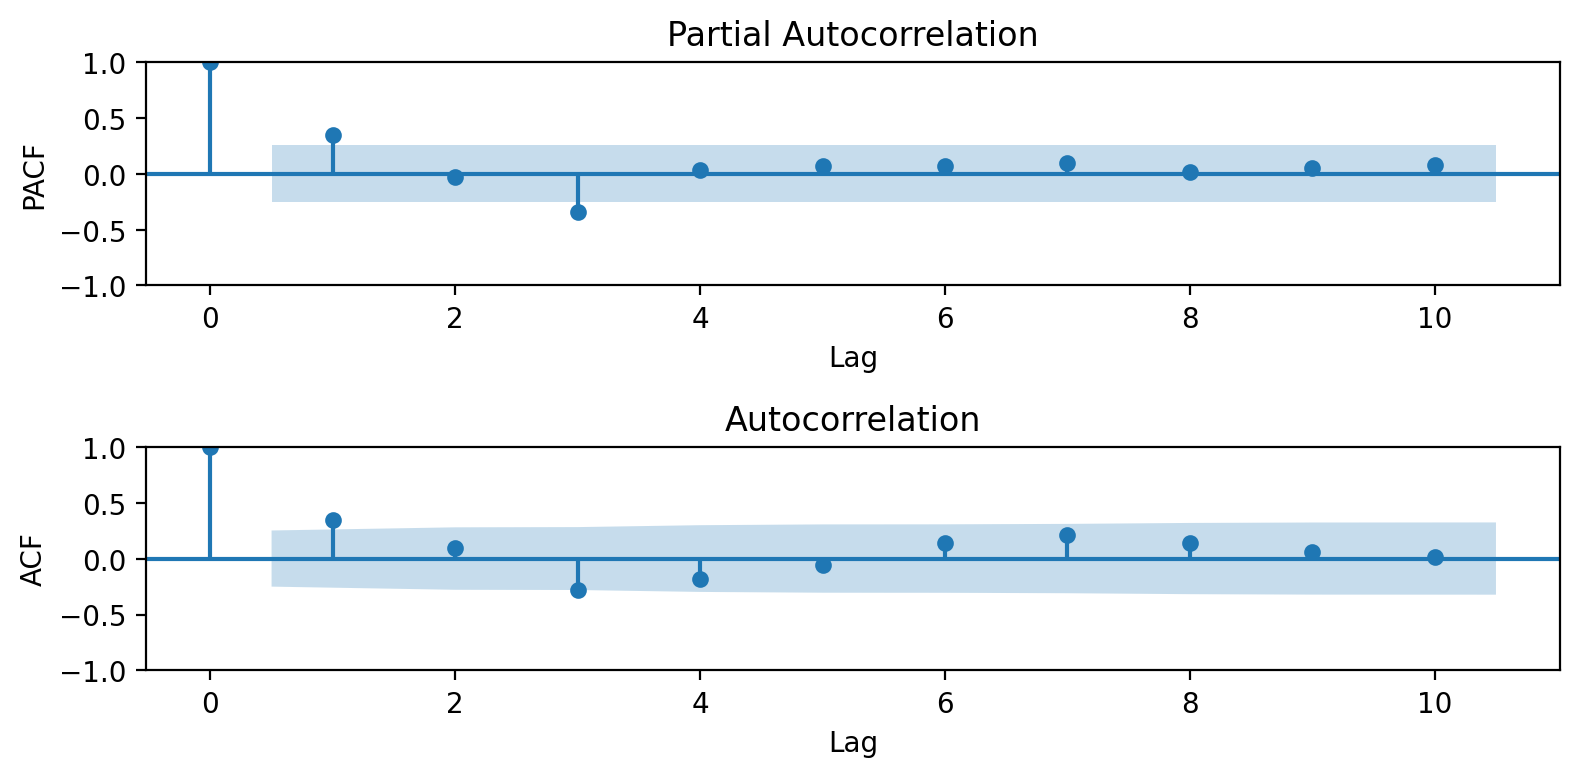

In [39]:
# make ACF and PACF plots
fig, axs = plt.subplots(2)
plot_pacf(daily_std_gmx, lags=10, method='ywm', ax=axs[0]) # partial autocorrelation 
axs[0].set_ylabel('PACF')
axs[0].set_xlabel('Lag')
plot_acf(daily_std_gmx, lags=10, ax=axs[1])  # autocorrelation
axs[1].set_ylabel('ACF')
axs[1].set_xlabel('Lag')
plt.tight_layout();

We see both PACF and ACF drops rapidly after lag1, so we can go with either
an AR(1) or MA(1).

In [41]:
ar1 = ARIMA(daily_std_gmx, order=(1,0,0)).fit()
ma1 = ARIMA(daily_std_gmx, order=(0,0,1)).fit()

In [43]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GMX   No. Observations:                   61
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -66.238
Date:                Mon, 12 Dec 2022   AIC                            138.476
Time:                        14:06:55   BIC                            144.808
Sample:                    10-01-2021   HQIC                           140.958
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1590      0.186      6.238      0.000       0.795       1.523
ar.L1          0.3425      0.108      3.163      0.002       0.130       0.555
sigma2         0.5126      0.090      5.712      0.000       0.337       0.689
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.86
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.19   Skew:                             1.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GMX   No. Observations:                   61
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -66.983
Date:                Mon, 12 Dec 2022   AIC                            139.966
Time:                        14:07:03   BIC                            146.299
Sample:                    10-01-2021   HQIC                           142.448
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1641      0.157      7.418      0.000       0.856       1.472
ma.L1          0.2679      0.116      2.300      0.021       0.040       0.496
sigma2         0.5257      0.098      5.373      0.000       0.334       0.718
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                15.88
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                             1.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""